I would like to introduce you to the Google Summer of Code project that I am currently working on it is a brigde `sherpa` and `astropy.modelling` 

So I made an API diagram showing the mapping between the two API 
<img src="files/Sherpa_Astropy_API_Mapping.png">

I'll show you our API for the bridge. Firstly lets import the SherpaFitter class which is the interface with sherpa's fitting routines. I'm also going to import some wrapper classes which will list some of the options we have for statistics, minimisation routines and uncertanty estimation methods.

In [1]:
from astropy.modeling.astro_sherpa import SherpaFitter, Stat, OptMethod, EstMethod

Let's look at the aviable options and select one of each

In [2]:
stat_class = Stat()
opt_class = OptMethod()
est_class = EstMethod()

print 'Statistics:', stat_class.list_stats()
print 'Optimatizers:', opt_class.list_optmethods()
print 'Estimation methods:', est_class.list_estmethods()

stat_class.set_stat('chi2')
opt_class.set_optmethod('levmar')
est_class.set_estmethod('convariance')

#or if you know what you want without having to look we can just initalise it with the name
stat = Stat('chi2')
opt = OptMethod('levmar')
est = EstMethod('convariance')



Statistics: ['leastsq', 'chi2', 'chi2modvar', 'chi2constvar', 'chi2gehrels', 'chi2datavar', 'chi2xspecvar']
Optimatizers: ['levmar', 'moncar', 'simplex', 'neldermead']
Estimation methods: ['confidence', 'covariance', 'projection']


We can now initalise the fitter with the requested setup.

In [3]:
sfitter = SherpaFitter(statistic=stat, optimizer=opt, estmethod=est)
# or simply 
sfitter = SherpaFitter(statistic='chi2', optimizer='levmar', estmethod='convariance')

Now we have a fitter lets quickly make some data and a model to fit

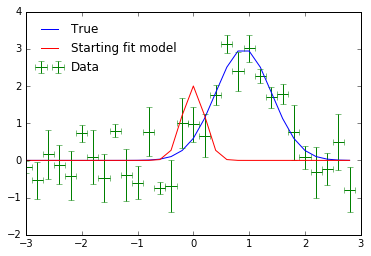

In [4]:
from astropy.modeling.models import Gaussian1D
import numpy as np
import  matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0x1337)

true = Gaussian1D(amplitude=3, mean=0.9, stddev=0.5)
err = 0.8
step = 0.2
x = np.arange(-3, 3, step)
y = true(x) + err * np.random.uniform(-1, 1, size=len(x))

yerrs=err * np.random.uniform(0.2, 1, size=len(x))
xerrs=(step / 2) * np.ones(x.shape)

fit_model = true.copy() # ofset fit model from true 
fit_model.amplitude = 2
fit_model.mean = 0
fit_model.stddev = 0.2
plt.plot(x,true(x), label="True")
plt.errorbar(x, y, xerr=xerrs, yerr=yerrs, ls="", label="Data")
plt.plot(x,fit_model(x), label="Starting fit model")
plt.legend(loc=(0.02,0.7), frameon=False)
_=plt.xlim((-3,3))

Now we have some data let's fit it and get hopefully we get something similar to "True" back.

As `sfitter` has already been initalised it at similarly to other astropy fitters we just call it with some data and an astropy model and  we get a fitted model returned 

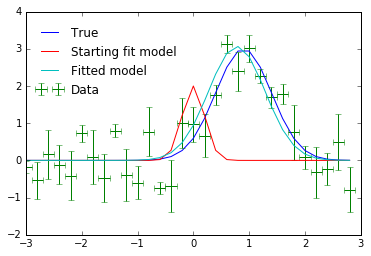

In [5]:
fitted_model = sfitter(fit_model,x, y, xerr=xerrs, yerr=yerrs)

plt.plot(x,true(x), label="True")
plt.errorbar(x, y, xerr=xerrs, yerr=yerrs, ls="", label="Data")
plt.plot(x,fit_model(x), label="Starting fit model")
plt.plot(x,fitted_model(x), label="Fitted model")
plt.legend(loc=(0.02,0.6), frameon=False)
_ = plt.xlim((-3,3))

That looks resonable so lets look at the fit statistic value

In [6]:
print 'Chi2:', sfitter.fit_info.statval
print 'DOF:', sfitter.fit_info.dof
print 'Chi2/DOF:', sfitter.fit_info.rstat

Chi2: 82.7366242121
DOF: 27
Chi2/DOF: 3.06431941526


Now we a fit lets look at the uncertanites on the parameters and plot the "min" and "max" model

In [7]:
param_errors = sfitter.est_errors(sigma=3)
min_model = fitted_model.copy()
max_model = fitted_model.copy()

for pname, pval, pmin, pmax in zip([p.split(".",1)[-1] for p in param_errors.parnames], param_errors.parvals, 
                                   param_errors.parmins, param_errors.parmaxes):
    print pname, pval, pmin, pmax
    getattr(min_model,pname).value = pval+pmin
    getattr(max_model,pname).value = pval+pmax
    

amplitude 3.06467892741 -0.529675180127 0.529675180127
mean 0.778538514198 -0.0964139944319 0.0964139944319
stddev 0.507219374547 -0.105919629294 0.105919629294


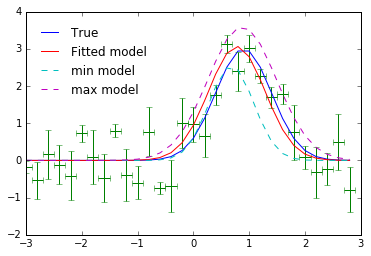

In [8]:
plt.plot(x,true(x), label="True")
plt.errorbar(x, y, xerr=xerrs, yerr=yerrs, ls="")
plt.plot(x,fitted_model(x), label="Fitted model")
plt.plot(x,min_model(x), label="min model", ls="--")
plt.plot(x,max_model(x), label="max model", ls="--")
plt.legend(loc=(0.02,0.6), frameon=False)
_ = plt.xlim((-3,3))

Ok well thats all well and good but we need to be able to build more complex models with linked parameters, bounds and fixed parameters. Fear not we can do that to. Simply make a compound model and/or set the tied,bounds and fixed parameters to your discression.

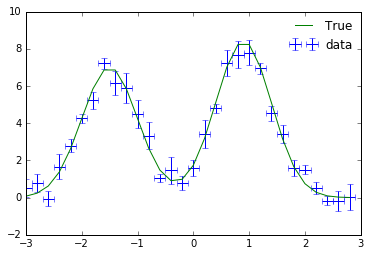

In [9]:
double_gaussian = true+true

def tiedfunc(self):
    return 1.2*self.amplitude_0

double_gaussian.amplitude_1.tied = tiedfunc
double_gaussian.amplitude_0.value = 7
double_gaussian.mean_0.value = -1.5


# without PR #5129 we need to do this!
#double_gaussian.amplitude_1.value=double_gaussian.amplitude_1.tied(double_gaussian)

yy = double_gaussian(x) + err * np.random.uniform(-1, 1, size=len(x))
yyerrs = err * np.random.uniform(0.2, 1, size=len(x))

plt.errorbar(x, yy, xerr=xerrs, yerr=yyerrs,ls="", label="data")
plt.plot(x,double_gaussian(x),label="True")
plt.legend(loc=(0.78,0.8), frameon=False)
_ = plt.xlim((-3,3))

So lets add some parameter constraints to the model and fit it
And we can print the sherpa model to check things are doing what they should.

In [10]:
fit_gg = double_gaussian.copy()
fit_gg.mean_0.value = -0.5
fit_gg.mean_0.min = -1.25
fit_gg.mean_1.value = 0.8
fit_gg.stddev_0.value = 0.9
fit_gg.stddev_0.fixed = True

fitted_gg = sfitter(fit_gg,x, yy, xerr=xerrs, yerr=yyerrs)
print(sfitter._fitmodel.sherpa_model)

free_gg = sfitter(double_gaussian.copy(),x, yy, xerr=xerrs, yerr=yyerrs)
print(sfitter._fitmodel.sherpa_model)


   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   wrap_.amplitude_0 thawed      5.15136 -3.40282e+38  3.40282e+38           
   wrap_.mean_0 thawed        -1.25        -1.25  3.40282e+38           
   wrap_.stddev_0 frozen          0.9 -3.40282e+38  3.40282e+38           
   wrap_.amplitude_1 linked      6.18163 expr: (1.2 * wrap_.amplitude_0)           
   wrap_.mean_1 thawed     0.902219 -3.40282e+38  3.40282e+38           
   wrap_.stddev_1 thawed     0.526412 -3.40282e+38  3.40282e+38           

   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   wrap_.amplitude_0 thawed      6.79197 -3.40282e+38  3.40282e+38           
   wrap_.mean_0 thawed     -1.62225 -3.40282e+38  3.40282e+38           
   wrap_.stddev_0 thawed     0.491676 -3.40282e+38  3.40282e+38           
   wrap_.amplitude_1 l

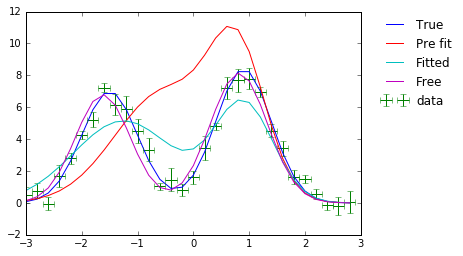

In [11]:
plt.plot(x,double_gaussian(x),label="True")
plt.errorbar(x, yy, xerr=xerrs, yerr=yyerrs,ls="", label="data")
plt.plot(x,fit_gg(x),label="Pre fit")
plt.plot(x,fitted_gg(x),label="Fitted")
plt.plot(x,free_gg(x),label="Free")

plt.legend(loc=(1.05,0.55), frameon=False)
_=plt.xlim((-3,3))

How about multiple models or multiple datasets. 
So we have three scenario we can handle:

data : models 
- n : n
- 1 : n
- n : 1

With any of the many scenarios we return a list of models. Firstly well look at a single dataset with the two models as above.

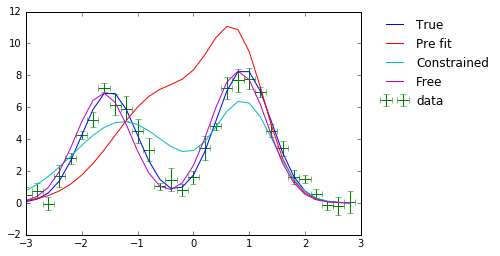

In [12]:
fit_gg = double_gaussian.copy()
fit_gg.mean_0.value = -0.5
fit_gg.mean_0.min = -1.25
fit_gg.mean_1.value = 0.8
fit_gg.stddev_0.value = 0.9
fit_gg.stddev_0.fixed = True

fitted_models = sfitter([fit_gg, double_gaussian.copy()], x, yy, xerr=xerrs, yerr=yyerrs)

plt.plot(x,double_gaussian(x),label="True")
plt.errorbar(x, yy, xerr=xerrs, yerr=yyerrs,ls="", label="data")
plt.plot(x, fit_gg(x),label="Pre fit")
plt.plot(x, fitted_models[0](x),label="Constrained")
plt.plot(x, fitted_models[1](x),label="Free")

plt.legend(loc=(1.05,0.55), frameon=False)
_=plt.xlim((-3,3))

We also can fit multiple datasets with a single model so lets make a second datset. You can also use `None` for when you dont have something like a missing xerrs.

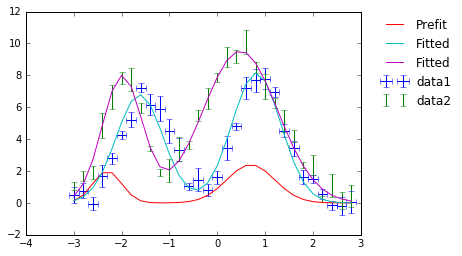

In [13]:
fit_gg=double_gaussian.copy()
fit_gg.mean_0 = -2.3
fit_gg.mean_1 = 0.7
fit_gg.amplitude_0 = 2
fit_gg.amplitude_1 = 3
fit_gg.stddev_0 = 0.3
fit_gg.stddev_1 = 0.5


second_gg = double_gaussian.copy()
second_gg.mean_0 = -2
second_gg.mean_1 = 0.5
second_gg.amplitude_0 = 8
second_gg.amplitude_1 = 5
second_gg.stddev_0 = 0.4
second_gg.stddev_1 = 0.8

yy2 = second_gg(x) + err * np.random.uniform(-1, 1, size=len(x))
yy2errs = err * np.random.uniform(0.2, 1, size=len(x))

plt.errorbar(x, yy, xerr=xerrs, yerr=yyerrs,ls="", label="data1")
plt.errorbar(x, yy2, yerr=yy2errs,ls="", label="data2")
plt.plot(x, fit_gg(x), label="Prefit")

fitted_model = sfitter(fit_gg, x=[x, x], y=[yy, yy2], xerr=[xerrs, None], yerr=[yyerrs, yy2errs])

plt.plot(x, fitted_model[0](x), label="Fitted")
plt.plot(x, fitted_model[1](x), label="Fitted")
plt.legend(loc=(1.05,0.55), frameon=False)